In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import random

In [2]:
# Define a scalar function
def f(x):
    return 3 * x ** 2 - 4 * x + 5

In [3]:
# Test function
f(3.0)

20.0

In [4]:
# Create values for plotting f(x)
# Create xs
xs = np.arange(-5, 5, 0.25)
# Create ys
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

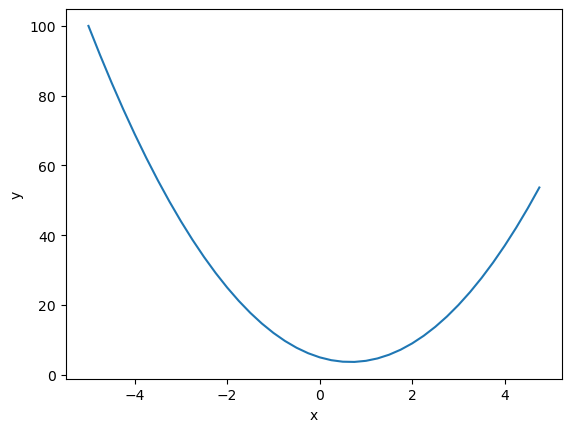

In [5]:
# Plot function
plt.plot(xs, ys)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [6]:
# Derivative of f(x) at  3 - numerically
h = 0.000000001
x = 3
print(f(x))
print(f(x + h))
derivative = (f(x + h) - f(x)) / h
print(f"The derivative of f(x) at x = 3 is {derivative} approximately.")

20
20.000000014
The derivative of f(x) at x = 3 is 14.000001158365194 approximately.


In [7]:
# Derivative of f(x) at  -3 - numerically
h = 0.000000001
x = -3
print(f(x))
print(f(x + h))
derivative = (f(x + h) - f(x)) / h
print(f"The derivative of f(x) at x = -3 is {derivative} approximately.")

44
43.999999978
The derivative of f(x) at x = -3 is -22.000001820288162 approximately.


In [8]:
# More complex case (multivariable)
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [9]:
# Evaluate the derivative numerically
h = 0.00001

a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
print("d1", d1)
a = a + h
d2 = a * b + c
print("d2", d2)
print("Derivative (slope) with respect to a:", (d1 - d2) / h)

d1 4.0
d2 3.9999699999999994
Derivative (slope) with respect to a: 3.000000000064062


In [10]:
# Neural Net Value class

class Value:
    
    def __init__(self, data, _children = (), _op = "", label = "") :
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __radd__(self, other): 
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (- other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float for now."
        out = Value(self.data ** other, (self, ), f"**{other}")
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out 

    def __rmul__(self, other):
        return self * other  
    
    def __truediv__(self, other):
        return self * other ** -1

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1)/ (math.exp(2 * x) + 1)
        out = Value(t, (self, ), "tanh")
        def _backward():
            self.grad += (1 - t ** 2) * out.grad 
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp") 

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        # Backpropagation 
        for node in reversed(topo):
            node._backward()

In [11]:
a = Value(2.0, label = "a")
b = Value(-3.0, label = "b")
c = Value(10, label = "c")
e = a * b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label = "f")
L = d * f; L.label = "L"
d

Value(data=4.0)

In [12]:
# Check previous nodes for d
d._prev

{Value(data=-6.0), Value(data=10)}

In [13]:
# Check operation between previous nodes for d
d._op

'+'

In [14]:
# Plotting computational graphs
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = "svg", graph_attr = {"rankdir": "LR"})  # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [15]:
# Manual backpropagation
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

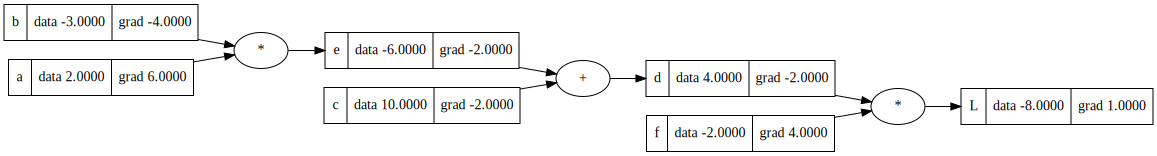

In [16]:
draw_dot(L)

In [17]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
e = a * b; 
d = e + c; 
L = d * f
print(L.data)

-7.286496


dd / dc ? 1.0
dd/ de 1.0
d = c + e
(f(x + h) - f(x))/h
((c+h + e) - (c + e)) / h
(c + h - c  - e) / h
h/ h = 1.0

In [18]:
def lol():
    """
    Calculates derivative numerically and prints it.
    """
    h = 0.0001

    a = Value(2.0, label = "a")
    b = Value(-3.0, label = "b")
    c = Value(10, label = "c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label = "f")
    L = d * f; L.label = "L"
    L1 = L.data

    a = Value(2.0 , label = "a")
    b = Value(-3.0, label = "b")
    b.data += h
    c = Value(10, label = "c")
    e = a * b; e.label = "e"
    d = e  + c ; d.label = "d"
    f = Value(-2.0 , label = "f")
    L = d * f; L.label = "L"
    L2 = L.data 

    print((L2 - L1) / h)

lol()

-4.000000000008441


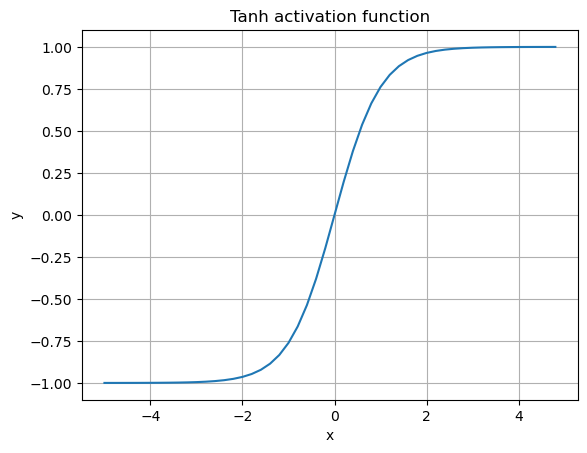

In [19]:
# Plotting tanh activation function
xs = np.arange(-5, 5, 0.2)
ys = np.tanh(xs)
plt.plot(xs, ys)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.title("Tanh activation function")
plt.show()

In [20]:
# inputs x1, x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")
# weights w1, w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "W2")
# bias b, special b value for nice numbers in backpropagation
b = Value(6.8813735870195432, label = "b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2 "
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

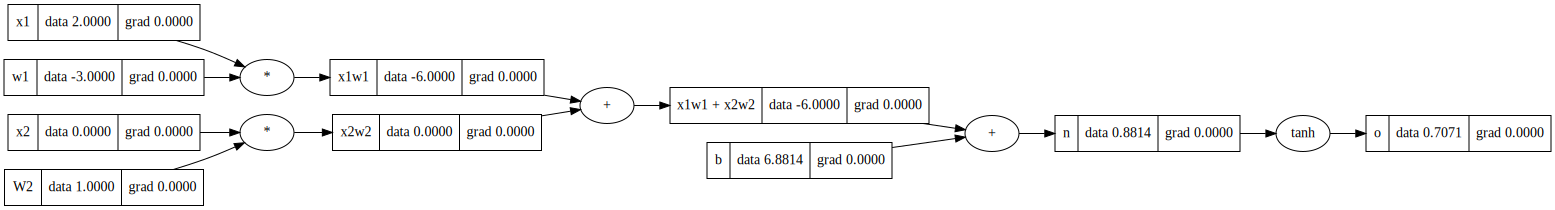

In [21]:
# Draw computational graph from node o
draw_dot(o)

In [22]:
# Manual backpropagation for a single neuron
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = 0.5
x1.grad = -1.5
w1.grad = 1.0

In [23]:
# o = tanh(n)
# do/dn = 1 -tanh(n) ** 2
1 - o.data ** 2

0.4999999999999999

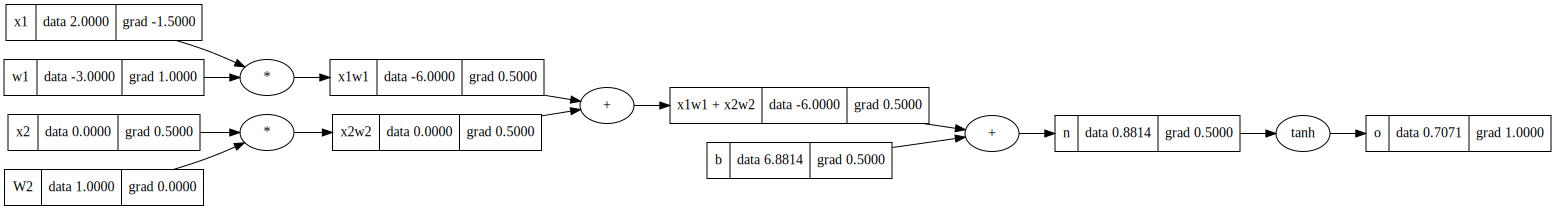

In [24]:
draw_dot(o)

In [25]:
# Reset variables
# inputs x1, x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")
# weights w1, w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "W2")
# bias b, special b value for nice numbers in backpropagation
b = Value(6.8813735870195432, label = "b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2 "
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

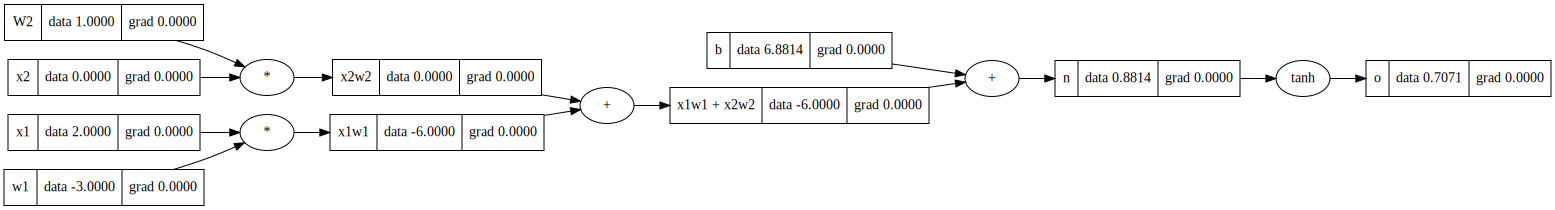

In [26]:
draw_dot(o)

In [27]:
# Backpropagation through calling _backward() manually
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

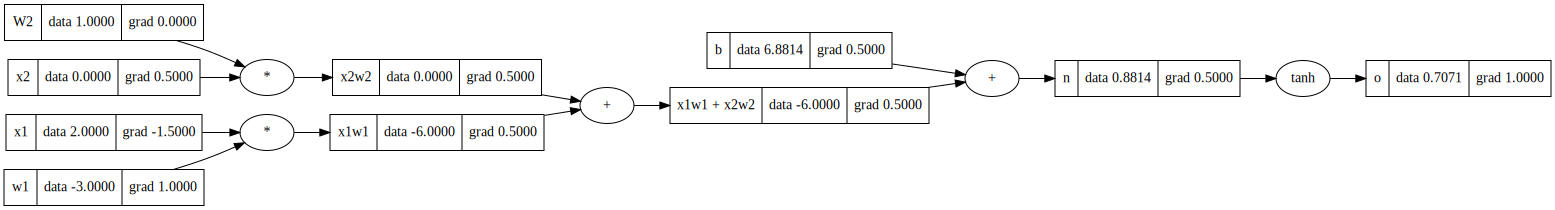

In [28]:
draw_dot(o)

In [29]:
# Reset variables
# inputs x1, x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")
# weights w1, w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "W2")
# bias b, special b value for nice numbers in backpropagation
b = Value(6.8813735870195432, label = "b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2 "
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

In [30]:
# Topological sorting
topo = []
visited = set()
def build_topo(v):
    visited.add(v)
    for child in v._prev:
        build_topo(child)
    topo.append(v)


# We need to call ._backward() in topological order
build_topo(o)

In [31]:
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [32]:
# Set initial gradient to 1
o.grad = 1.0

# Backpropagation 
for node in reversed(topo):
    node._backward()

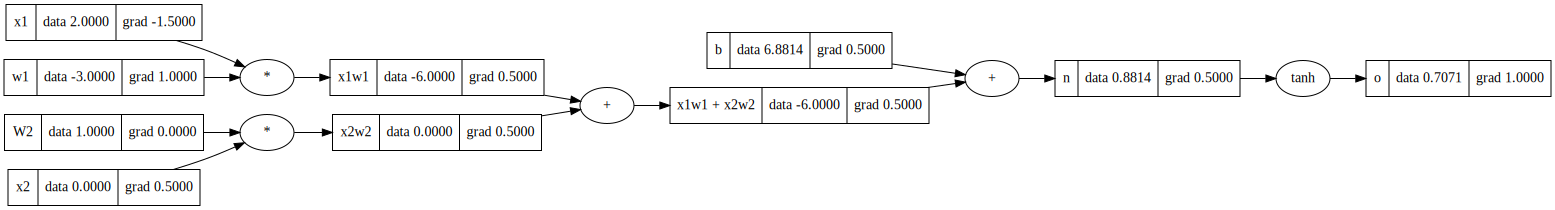

In [33]:
draw_dot(o)

In [34]:
# Reset variables
# inputs x1, x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")
# weights w1, w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "W2")
# bias b, special b value for nice numbers in backpropagation
b = Value(6.8813735870195432, label = "b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2 "
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

In [35]:
# Backpropagation
o.backward()

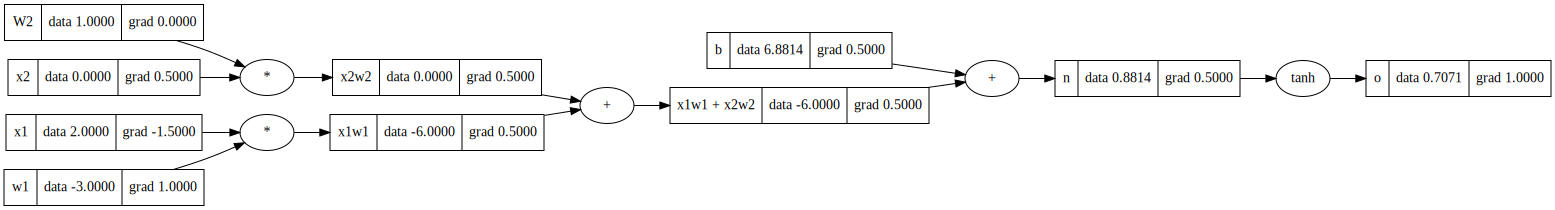

In [36]:
draw_dot(o)

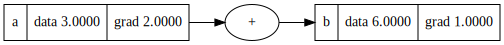

In [37]:
# Bug hunting
a = Value(3.0, label = "a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)

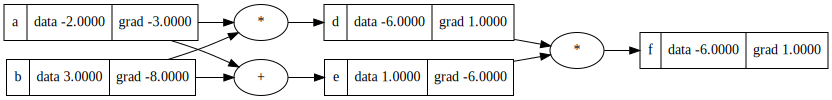

In [38]:
# Bug hunting continued
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

We have to accumulate gradients to account for the common case where a value is used more than once in a computation.

In [39]:
# Fix addition
a = Value(2.0)
a + 1

Value(data=3.0)

In [40]:
# Fix multiplication
a = Value(2.0)
a * 3

Value(data=6.0)

In [41]:
a = Value(2.0)
3 * a

Value(data=6.0)

In [42]:
# Fixing division
a = Value(2.0)
b = Value(4.0)
print(a / b)
print(b / a)

Value(data=0.5)
Value(data=2.0)


In [43]:
# Fixing subtraction
a = Value(4.0)
b = Value(2.0)
print(a - b)
print(b - a)

Value(data=2.0)
Value(data=-2.0)


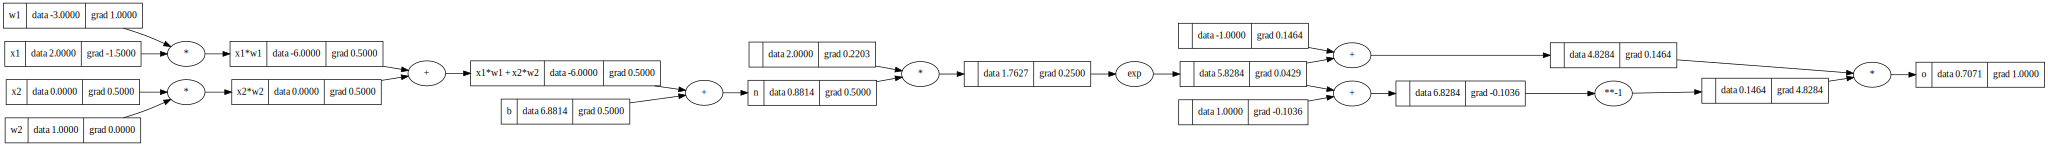

In [44]:
# Breaking up tanh into individual operations
# Reset variables
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
# Backpropagation with broken up tanh
o.backward()
draw_dot(o)

In [45]:
# The same example using PyTorch
x1 = torch.Tensor([2.0]).double()                
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [46]:
# More complicated tensors
tensor = torch.Tensor([[1, 2, 3], [4, 5, 6]])
tensor.shape

torch.Size([2, 3])

In [47]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)  
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, min, nout):
        self.neurons = [Neuron(min) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)== 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + list(nouts)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
mlp = MLP(3, (4, 4, 1))
mlp(x) 

Value(data=0.795725035030549)

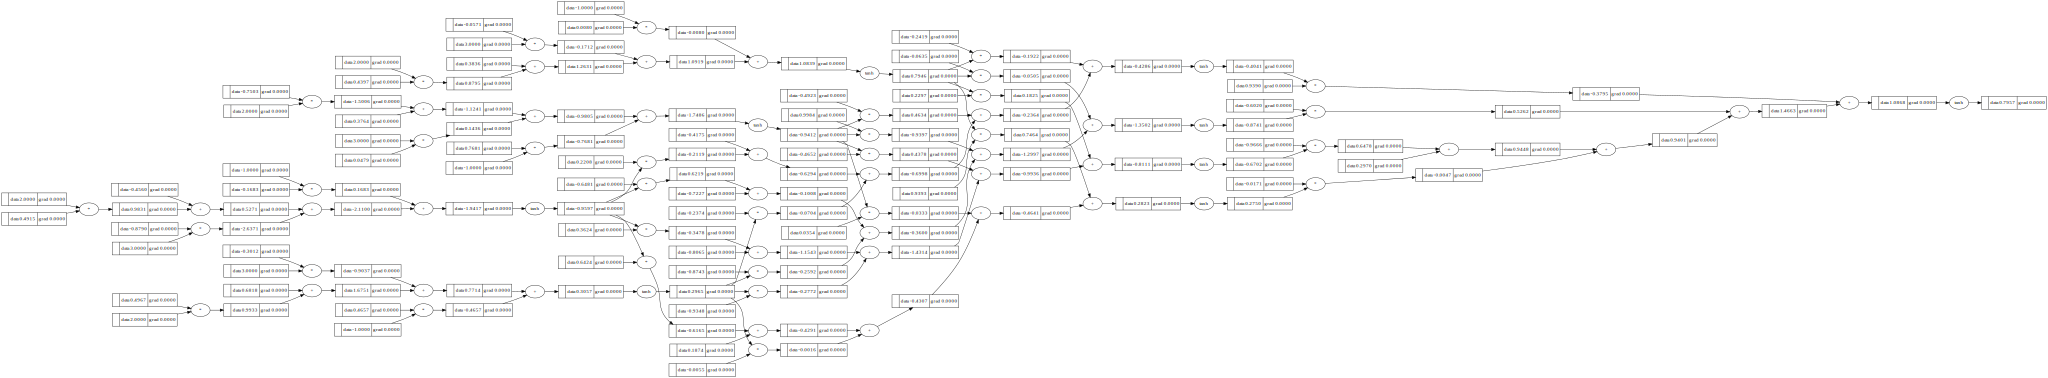

In [48]:
draw_dot(mlp(x))

In [49]:
# Sample dataset
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
# Desired targets
ys = [1.0, -1.0, -1.0, 1.0] 

In [50]:
# Current predictions (with no training)
predictions = [mlp(x) for x in xs]
predictions

[Value(data=0.795725035030549),
 Value(data=0.858732850886308),
 Value(data=0.5153078387929256),
 Value(data=0.8195700196549169)]

In [51]:
# Calculate losses
losses = [(youts - ygt)** 2 for ygt, youts in zip(ys, predictions)]
losses

[Value(data=0.04172826131327042),
 Value(data=3.4548878109639416),
 Value(data=2.2961578463072874),
 Value(data=0.03255497780732706)]

In [52]:
# Sum losses
loss = sum([(youts - ygt)** 2 for ygt, youts in zip(ys, predictions)])
loss

Value(data=5.825328896391826)

In [53]:
# Backpropagation - calculate gradients
loss.backward()

In [54]:
# Weights of the first neuron in the first layer
mlp.layers[0].neurons[0].w

[Value(data=0.4915382939981563),
 Value(data=-0.8790349966792266),
 Value(data=-0.1683087014143927)]

In [55]:
# Gradient of the weights of the first neuron in the first layer
mlp.layers[0].neurons[0].w[0].grad

0.11286630140158312

In [56]:
# Massive graph
# draw_dot(loss)

In [57]:
# Number of parameters for this MLP
len(mlp.parameters())

41

In [58]:
# Update parameters
for p in mlp.parameters():
    p.data += -0.01 * p.grad

In [59]:
mlp.layers[0].neurons[0].w[0].data

0.4904096309841405

In [60]:
# New predictions (after one iteration of gradient descent)
predictions = [mlp(x) for x in xs]

# Loss going down
loss = sum([(youts - ygt)** 2 for ygt, youts in zip(ys, predictions)])
loss.backward
loss

Value(data=5.457155903024068)

In [61]:
# Training for 20 iterations
for k in range(20):
    # Forward pass
    predictions = [mlp(x) for x in xs]

    # Calculate loss
    loss = sum([(youts - ygt)** 2 for ygt, youts in zip(ys, predictions)])

    # Zero the gradients
    for p in mlp.parameters():
        p.grad = 0.0

    # Backprop
    loss.backward()

    # Update parameters
    for p in mlp.parameters():
        p.data += -0.1 * p.grad

    print(f"Iteration: {k + 1} | Loss: {loss.data}")

Iteration: 1 | Loss: 5.457155903024068
Iteration: 2 | Loss: 2.83470406305814
Iteration: 3 | Loss: 2.519588566597233
Iteration: 4 | Loss: 1.9294921418258024
Iteration: 5 | Loss: 1.9681487191626397
Iteration: 6 | Loss: 0.02102994235547416
Iteration: 7 | Loss: 0.01951790847566574
Iteration: 8 | Loss: 0.018216699258655187
Iteration: 9 | Loss: 0.017084963578060143
Iteration: 10 | Loss: 0.016091496685052307
Iteration: 11 | Loss: 0.015212307111290011
Iteration: 12 | Loss: 0.014428646239040596
Iteration: 13 | Loss: 0.013725650692864064
Iteration: 14 | Loss: 0.013091385974987319
Iteration: 15 | Loss: 0.012516159395576706
Iteration: 16 | Loss: 0.011992017750503755
Iteration: 17 | Loss: 0.011512374252777676
Iteration: 18 | Loss: 0.011071727500752786
Iteration: 19 | Loss: 0.010665447034986264
Iteration: 20 | Loss: 0.010289607774681268


In [ ]:
# Predictions after training
predictions = [mlp(x) for x in xs]
predictions

[Value(data=0.9830463905146547),
 Value(data=-0.9336813033440255),
 Value(data=-0.9331391570564178),
 Value(data=0.9719840386229271)]